# Amazon SageMaker Asynchronous Inference using MONAI Application Package container

Amazon SageMaker Asynchronous Inference is a new capability in SageMaker that queues incoming requests and processes them asynchronously. SageMaker currently offers two inference options for customers to deploy machine learning models: 1) a real-time option for low-latency workloads 2) Batch transform, an offline option to process inference requests on batches of data available upfront. Real-time inference is suited for workloads with payload sizes of less than 6 MB and require inference requests to be processed within 60 seconds. Batch transform is suitable for offline inference on batches of data.Asynchronous inference is a new inference option for near real-time inference needs. Requests can take up to 15 minutes to process and have payload sizes of up to 1 GB. Asynchronous inference is suitable for workloads that do not have sub-second latency requirements and have relaxed latency requirements. For example, you might need to process an inference on a large image of several MBs within 5 minutes. In addition, asynchronous inference endpoints let you control costs by scaling down endpoints instance count to zero when they are idle, so you only pay when your endpoints are processing requests. [Example notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/async-inference/Async-Inference-Walkthrough.ipynb) is available for more implementation details.


Let's start by creating a SageMaker session and specifying:
- The S3 bucket and prefix that you want to use for the model. 
- The IAM role arn used to give hosting access to your data.

In [2]:
import os
import boto3
import time
import sagemaker
from time import strftime, gmtime
from sagemaker import image_uris

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client(service_name="sagemaker-runtime")

account_id = boto3.client("sts").get_caller_identity()["Account"]
region = boto3.Session().region_name

bucket = "sagemaker-{}-{}".format(region, account_id)
prefix= "medicalimaging-async-map"

### The Inference Script

An implementation of `model_fn` is required for inference script. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `model_fn` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

Here's an example of the inference script:

In [3]:
!pygmentize src/code/inference.py

import glob
import json
import logging
import os
import torch
from importlib import import_module
import boto3

from app import AISpleenSegApp

# from Api import MedicalImaging 
from AHItoDICOMInterface.AHItoDICOM import AHItoDICOM
helper = AHItoDICOM()

JSON_CONTENT_TYPE = 'application/json'

account_id = boto3.client("sts").get_caller_identity()["Account"]
region = boto3.Session().region_name

def model_fn(model_dir, context):
    logging.info("##### context system properties: {}".format(context.system_properties))
    logging.info("##### model files: {}".format(os.listdir( model_dir )))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.jit.load(model_dir+'/model.ts', map_location=device)
    
    monai_app_instance = AISpleenSegApp(helper, do_run=False, path="/home/model-server")
    logging.info(f"#### MONAI App Info: {monai_app_instance.get_package_info()}")

    return monai_app_instance


def input_fn(serialized_input_data, content_type=

### Package the pre-trained model and upload it to S3

In [4]:
!cd src && tar czvf ../model.tar.gz *

fObj = open("model.tar.gz", "rb")
key = os.path.join(prefix, "model.tar.gz")
boto3.Session().resource("s3").Bucket(bucket).Object(key).upload_fileobj(fObj)
model_url = "s3://{}/{}".format(bucket, key)
model_url

Dockerfile
__pycache__/
__pycache__/ahli_data_loader_operator.cpython-37.pyc
__pycache__/AHLIDataDICOMizer.cpython-37.pyc
__pycache__/AHLIFrameFetcher.cpython-37.pyc
__pycache__/Api.cpython-37.pyc
__pycache__/AHLItoDICOM.cpython-37.pyc
__pycache__/AHLIClientFactory.cpython-37.pyc
buildspec.yml
code/
code/app.py
code/requirements.txt
code/.ipynb_checkpoints/
code/.ipynb_checkpoints/ahi_data_loader_operator-checkpoint.py
code/.ipynb_checkpoints/Api-checkpoint.py
code/.ipynb_checkpoints/app-checkpoint.py
code/.ipynb_checkpoints/inference-checkpoint.py
code/.ipynb_checkpoints/requirements-checkpoint.txt
code/inference.py
code/Api.py
code/__pycache__/
code/__pycache__/Api.cpython-310.pyc
code/__pycache__/ahli_data_loader_operator.cpython-37.pyc
code/__pycache__/Api.cpython-37.pyc
code/ahi_data_loader_operator.py
dockerd-entrypoint.py
model.ts
model_handler.py


's3://sagemaker-us-east-1-749291336608/medicalimaging-async-map/model.tar.gz'

### Create a model object

We will use SageMaker boto3 client [Create Model API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html) to create the Model entity for multi-model endpoints, with the container definition, ModelName, and ExecutionRoleArn.

In [5]:
# Specify an AWS container image and region as desired
container = image_uris.retrieve(
    region=region, 
    image_scope="inference", 
    framework="pytorch", 
    version="1.12.1", 
    py_version="py38", 
    instance_type="ml.g4dn.2xlarge"
)

model_name = "DEMO-MONAIDeployAsyncModel-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": container,
        "ModelDataUrl": model_url,
    },
)

print(f"Created Model: {create_model_response['ModelArn']}")

Created Model: arn:aws:sagemaker:us-east-1:749291336608:model/demo-monaideployasyncmodel-2023-07-28-20-14-54


### Create endpoint configuration
Create a multi-model endpoint configurations using create_endpoint_config boto3 API. Specify an accelerated GPU computing instance in InstanceType, in this post we will use g4dn.xlarge instance. We recommend configuring your endpoints with at least two instances. This allows SageMaker to provide a highly available set of predictions across multiple Availability Zones for the models.

In [6]:
endpoint_config_name = "DEMO-MONAIDeployAsyncEndpointConfig-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint config name: " + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.2xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{prefix}/output",
            # Optionally specify Amazon SNS topics
            # "NotificationConfig": {
            # "SuccessTopic": "arn:aws:sns:::",
            # "ErrorTopic": "arn:aws:sns:::",
            # }
        },
        "ClientConfig": {"MaxConcurrentInvocationsPerInstance": 1},
    },
)

print("Endpoint config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint config name: DEMO-MONAIDeployAsyncEndpointConfig-2023-07-28-20-14-55
Endpoint config Arn: arn:aws:sagemaker:us-east-1:749291336608:endpoint-config/demo-monaideployasyncendpointconfig-2023-07-28-20-14-55


### Create endpoint
Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to InService once the deployment is successful.

In [7]:
endpoint_name = "DEMO-MONAIDeployAsyncEndpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint name: " + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Endpoint name: DEMO-MONAIDeployAsyncEndpoint-2023-07-28-20-14-55
Endpoint Arn: arn:aws:sagemaker:us-east-1:749291336608:endpoint/demo-monaideployasyncendpoint-2023-07-28-20-14-55
Status: Creating
Waiting for endpoint to create...
Endpoint Status: InService


## Invoke models
Once the endpoint is successfully created, we can send inference request to multi-model endpoint using invoke_enpoint API. We specify the TargetModel in the invocation call and pass in the payload for each model type. Sample invocation for PyTorch model and TensorRT model is shown below

Now we invoke the models that we uploaded to S3 previously. The first invocation of a model may be slow, since behind the scenes, SageMaker is downloading the model artifacts from S3 to the instance and loading it into the container.

In [8]:
InputLocation = sess.upload_data(
        'inputImageSets.json',
        bucket=sess.default_bucket(),
        key_prefix=prefix,
        extra_args={"ContentType": "application/json"},
)

response = runtime_sm_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=InputLocation,
    ContentType="application/json",
    Accept="application/json",
)
output_location = response["OutputLocation"]
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-east-1-749291336608/medicalimaging-async-map/output/5efef81b-b84d-48cb-a778-b3dfdc3e2b67.out


### Download Model Prediction Results

In [30]:
import boto3, json

s3 = boto3.client('s3')
res = s3.get_object(Bucket=output_location.split('/')[2], Key=('/').join( output_location.split('/')[3:] ))
for dcm in json.loads(res['Body'].read().decode('UTF-8')).keys():
    s3.download_file(dcm.split('/')[2], ('/').join( dcm.split('/')[3:] ), 'model_output.dcm')

### Visualize Segmentation Results

In [32]:
!pip install -q "itk>=5.3rc4" "itkwidgets[all]>=1.0a23"


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



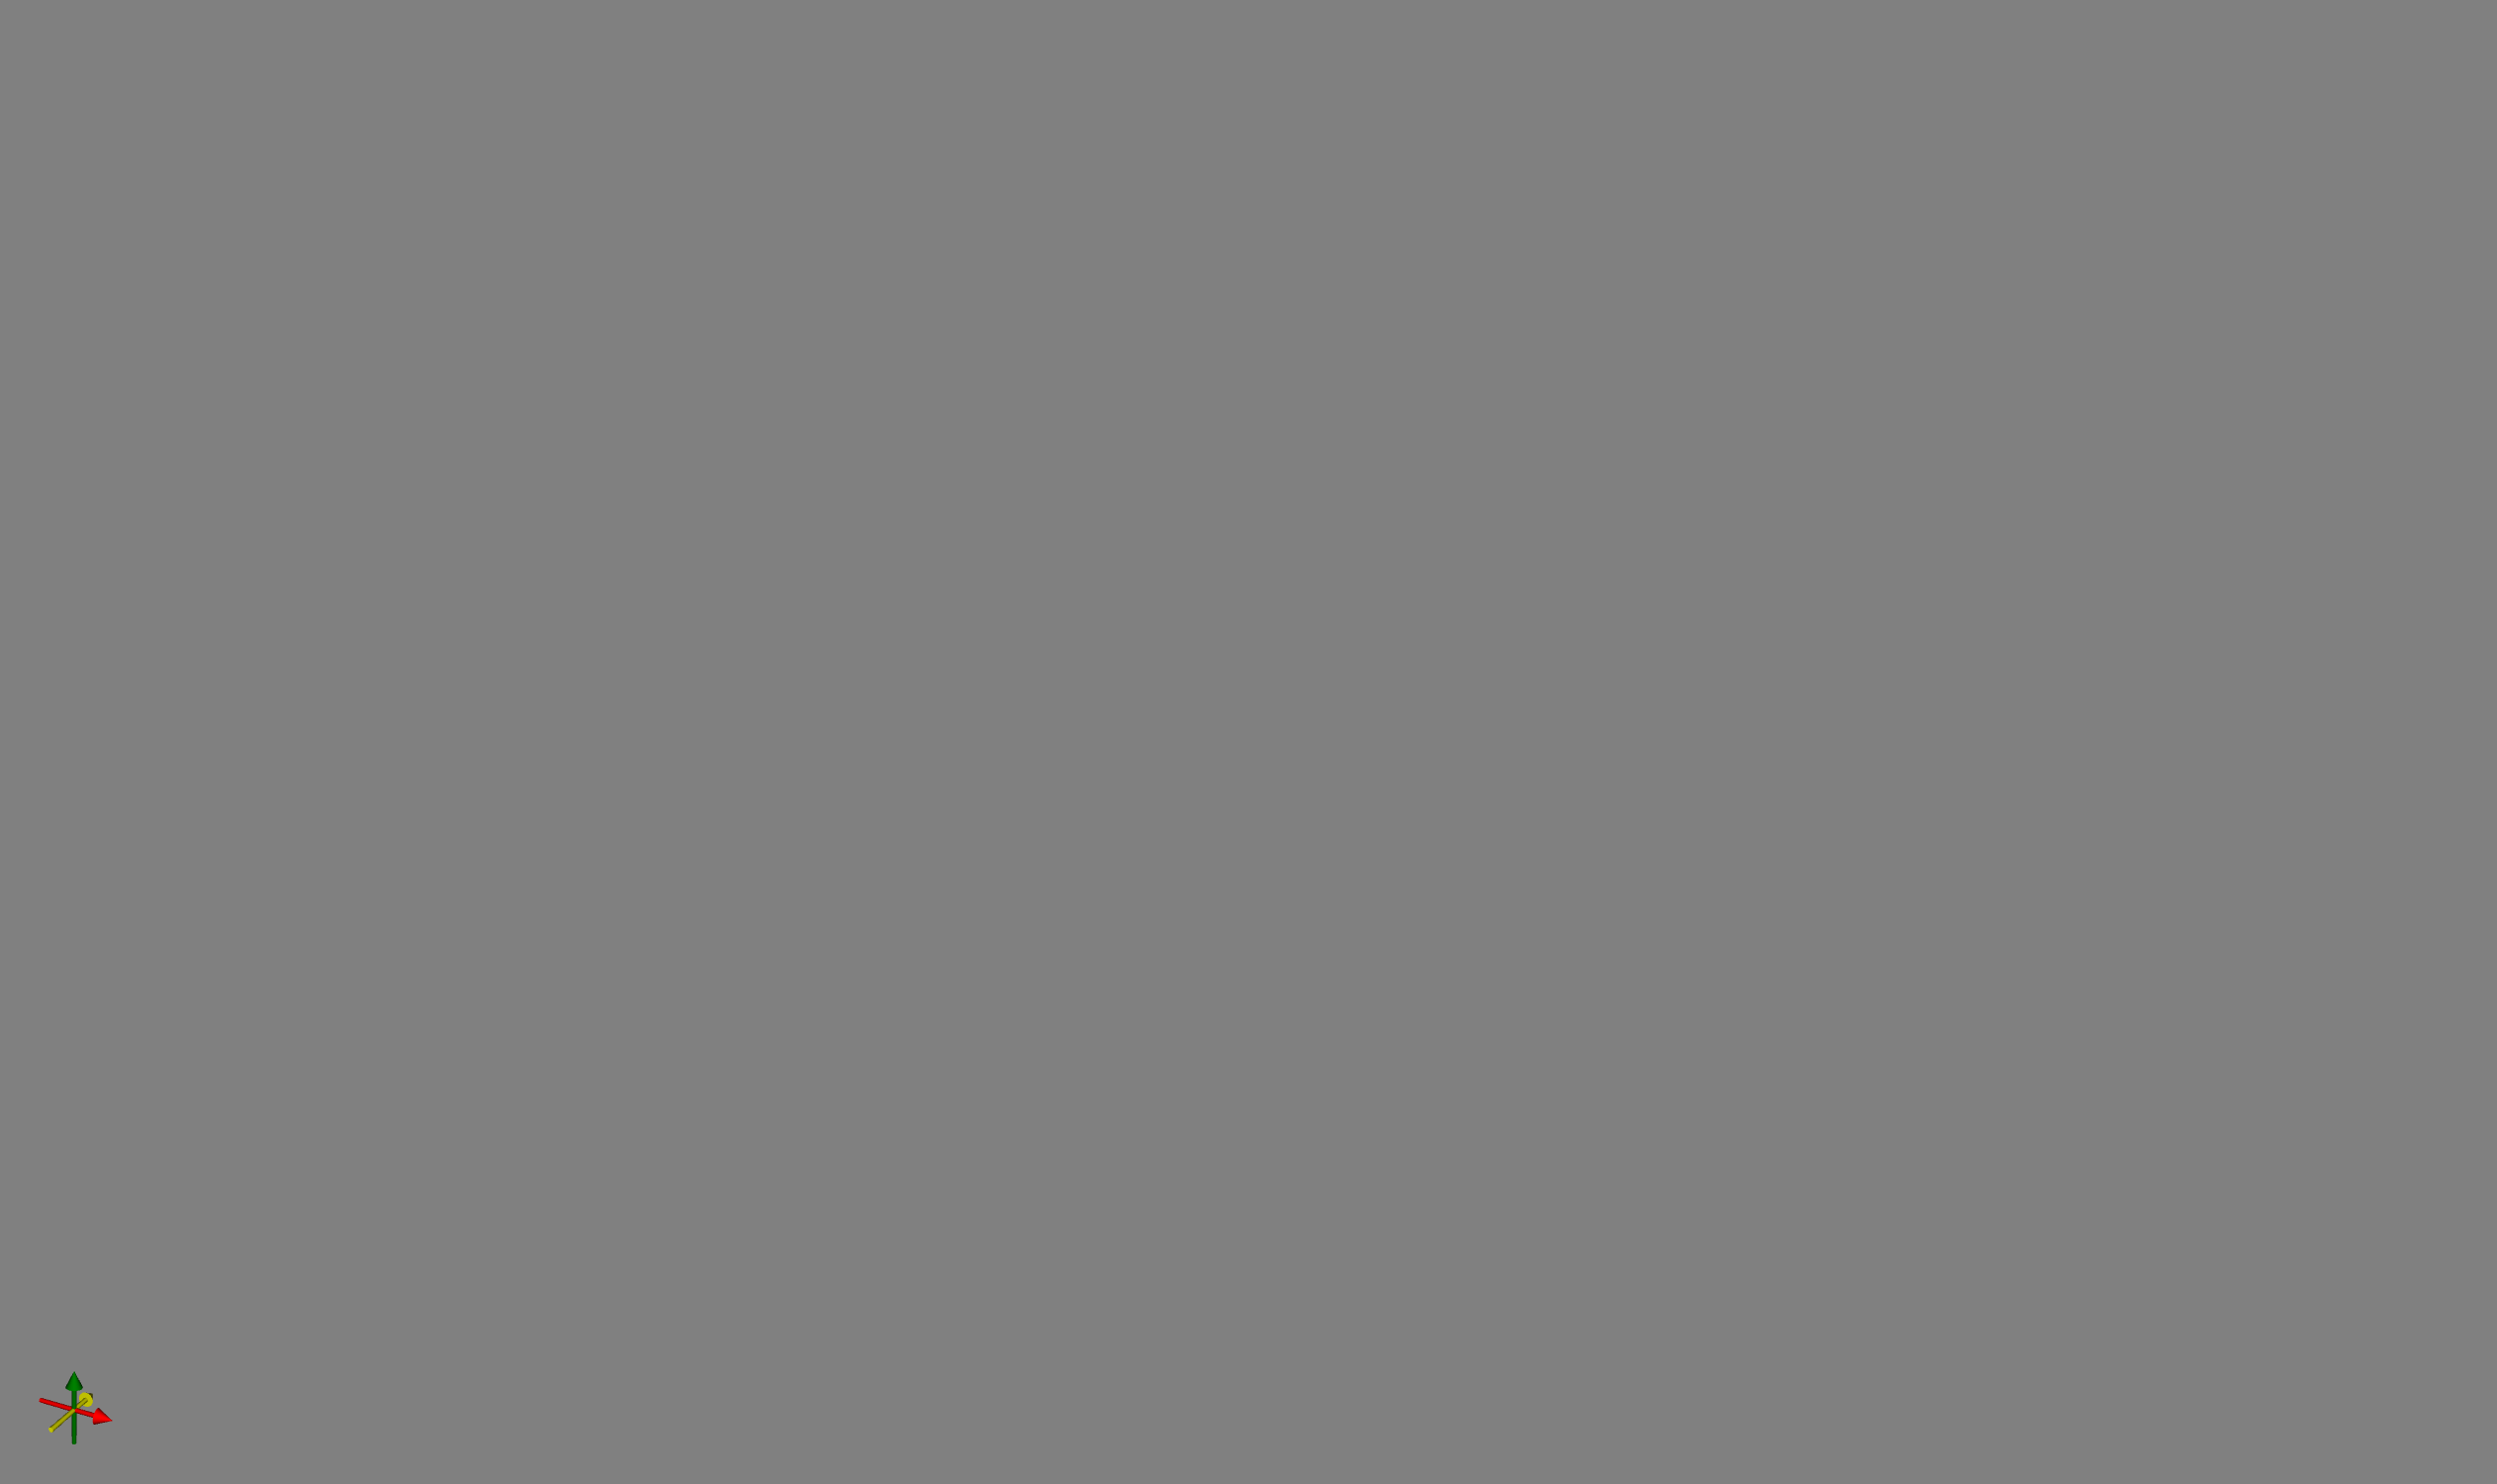
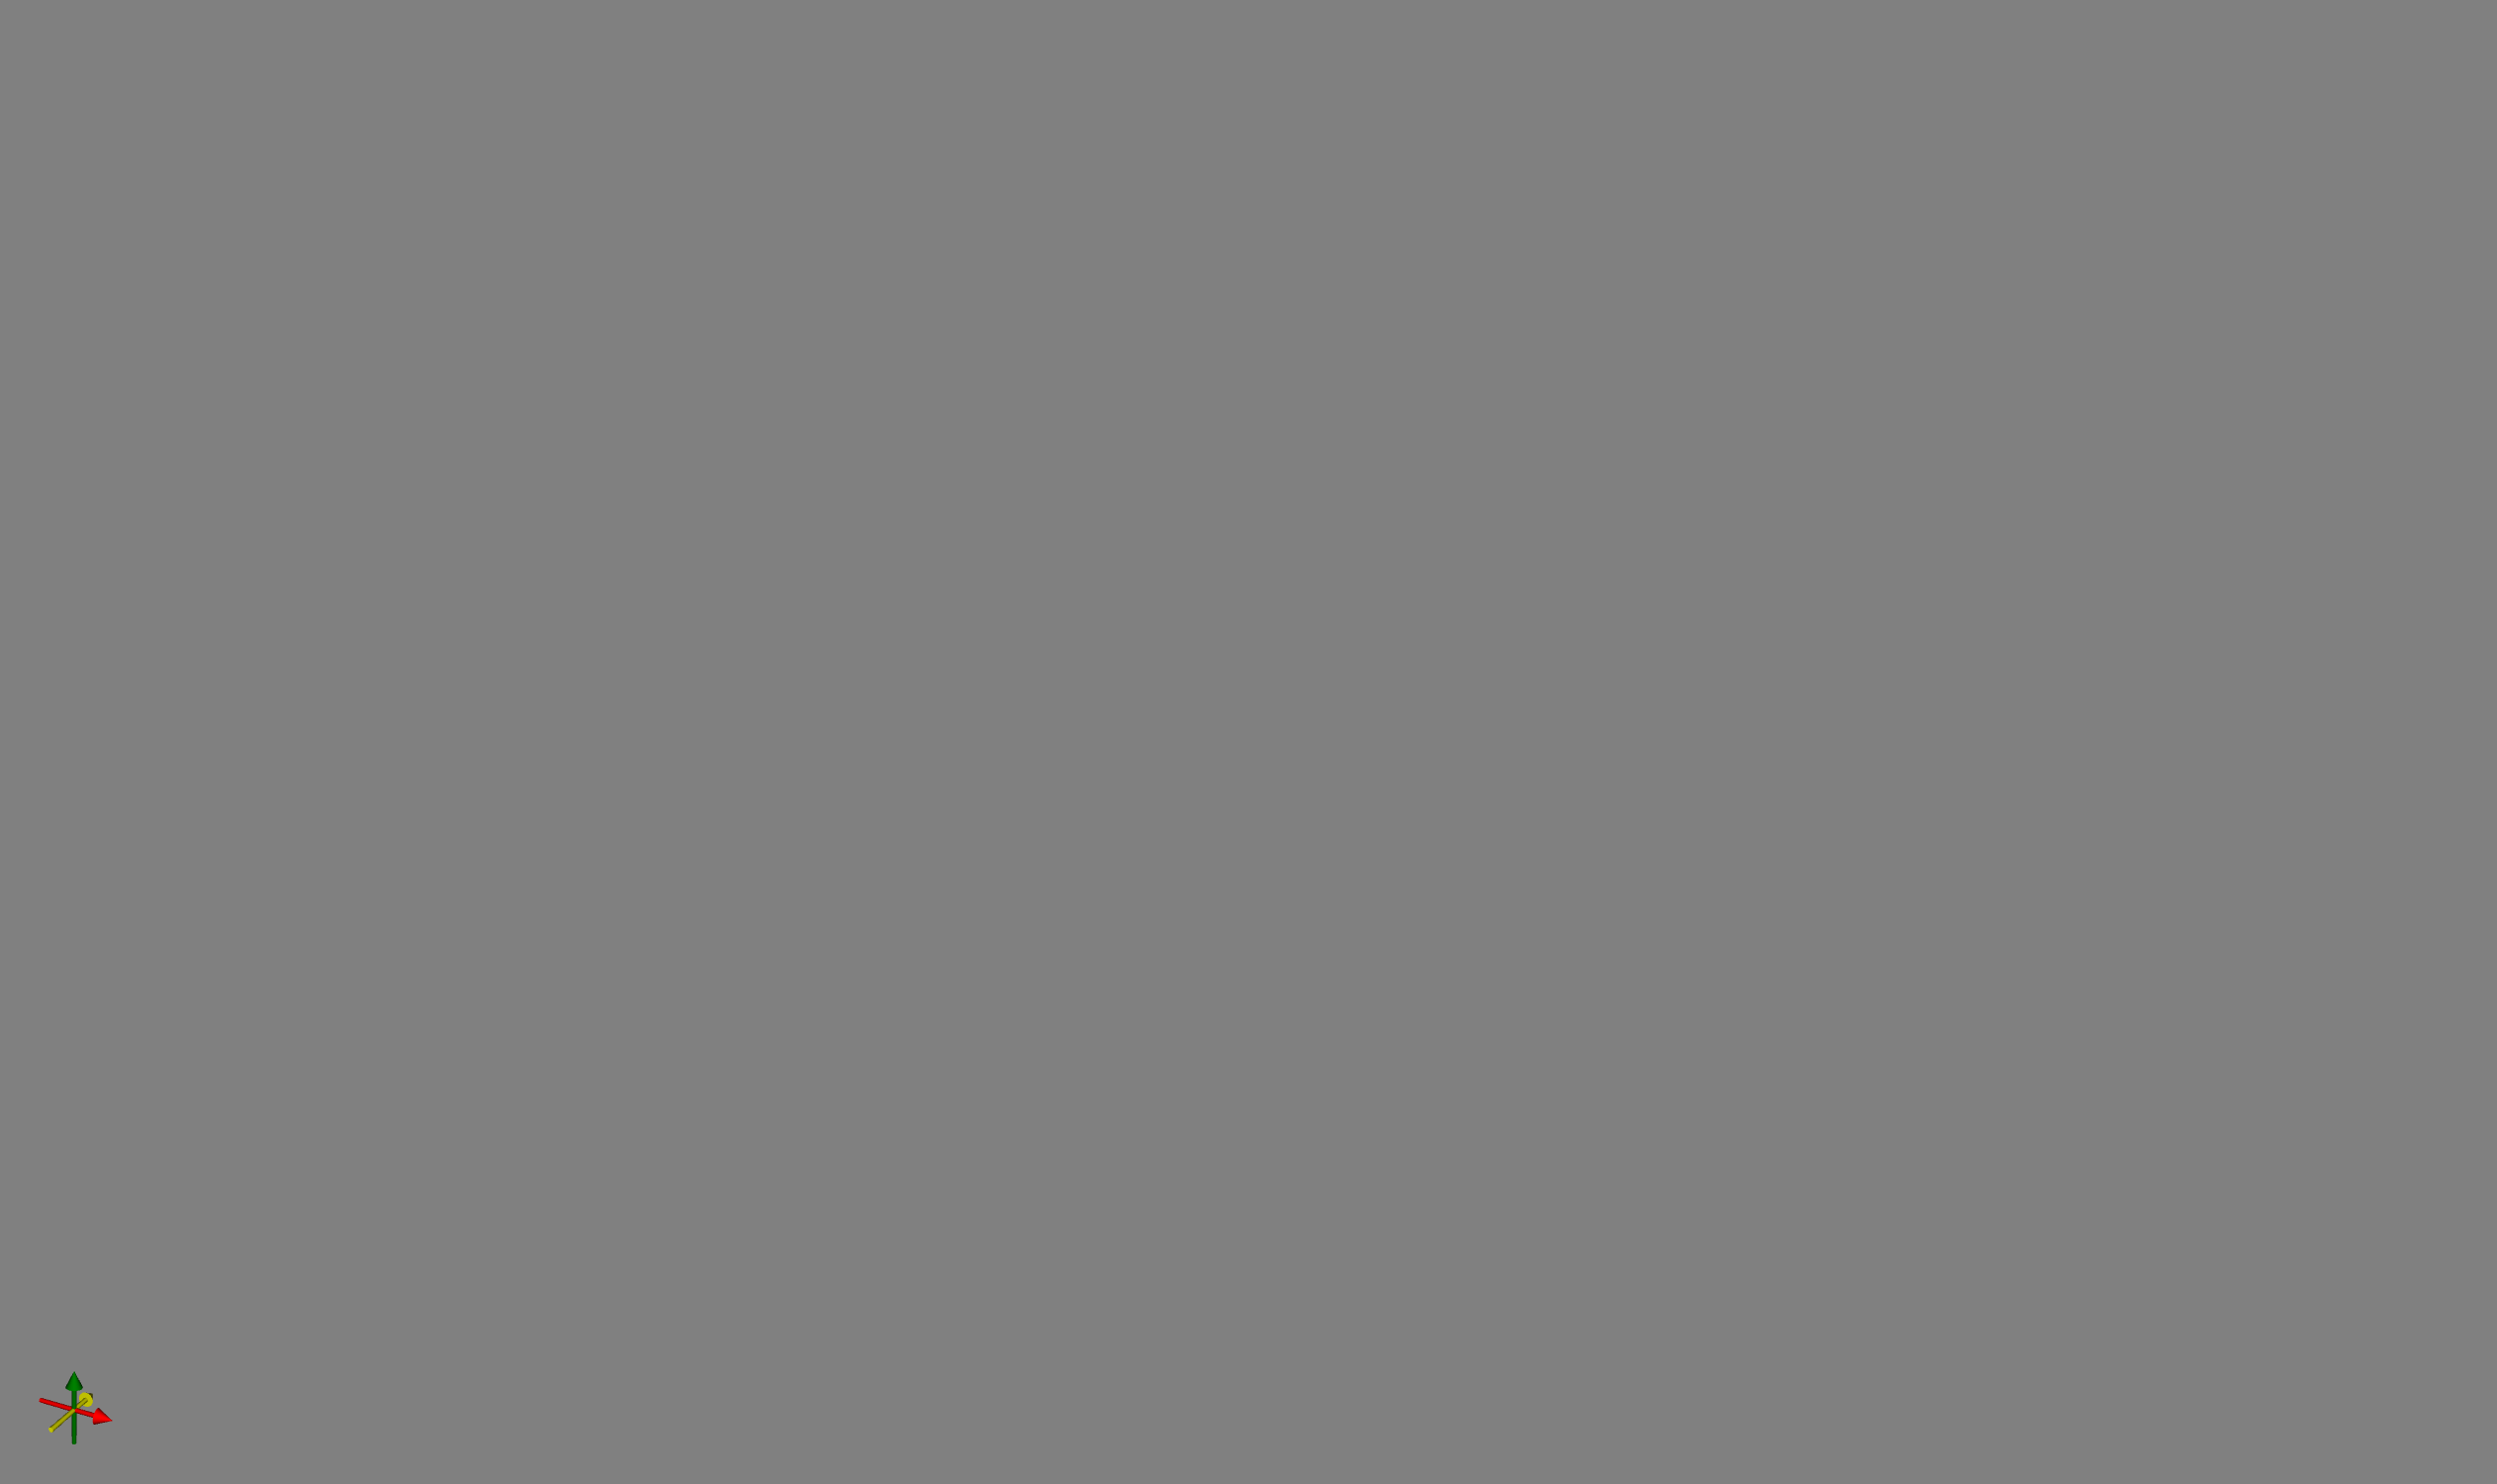

<IPython.core.display.Javascript object>

In [33]:
import itk
from itkwidgets import view

outputimg = itk.imread('model_output.dcm')
viewer = view(image=outputimg)

### 3. Delete the hosting resources

In [9]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'cbd1fa56-b873-489d-ab9f-7535e5e57c2d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cbd1fa56-b873-489d-ab9f-7535e5e57c2d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 28 Jul 2023 20:31:04 GMT'},
  'RetryAttempts': 0}}